In [ ]:
import torch

gpu_index = 6
torch.cuda.set_device(gpu_index)

print(torch.cuda.current_device())

In [2]:
import os
import time
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from monai import transforms
from monai.config import print_config
from monai.utils import first, set_determinism
from monai.data import CacheDataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

from generative.inferers import DiffusionInferer, LatentDiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler, PNDMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/envs/environment/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.10.1
Pillow version: 10.1.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT

In [3]:
set_determinism(33)

In [4]:
def load_images_and_labels(data_dir, label):
    image_files = glob.glob(os.path.join(data_dir, '*.jpg'))
    return [{"image": img, "label": label} for img in image_files]

In [5]:
# Directories for different tumor classes
directories = [ ("/root/group2/data/Training/meningioma", "meningioma") ]

# Load and concatenate data from all directories
all_data = []
for data_dir, label in directories:
    all_data.extend(load_images_and_labels(data_dir, label))

# Now split the data into training and validation sets
split_ratio = 0.8
split_index = int(len(all_data) * split_ratio)
train_data = all_data[:split_index]
val_data = all_data[split_index:]


transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)


# Continue with your existing code for creating datasets and dataloaders...
train_ds = CacheDataset(data=train_data, transform=transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, persistent_workers=True)

val_ds = CacheDataset(data=val_data, transform=transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4, persistent_workers=True)

Loading dataset:  55%|█████▍    | 350/641 [00:00<00:00, 734.18it/s]

Loading dataset: 100%|██████████| 161/161 [00:00<00:00, 737.80it/s]


In [6]:
check_data = next(iter(train_loader))
print(f"batch shape: {check_data['image'].shape}")
images = check_data['image']

# Concatenate the first four images in the batch along width
# The images tensor is already in the shape [batch_size, 1, height, width] because they are grayscale
image_visualisation = torch.cat(
    [images[0, 0], images[1, 0], images[2, 0], images[3, 0]], dim=1
)


# Visualize the concatenated images
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, cmap="gray")
plt.axis("off")
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)

plt.show()

batch shape: torch.Size([16, 1, 128, 128])


In [7]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=128,
)
model.to(device)

ddpm_scheduler = DDPMScheduler(num_train_timesteps=1000)
ddim_scheduler = DDIMScheduler(num_train_timesteps=1000)
pndm_scheduler = PNDMScheduler(num_train_timesteps=1000, skip_prk_steps=True)

# the range of sampling steps we want to use when testing the DDIM and PNDM schedulers
sampling_steps = [1000, 500, 200, 50]


optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)
inferer = DiffusionInferer(scheduler=ddpm_scheduler)

Epoch 0:   0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 63.98it/s]


100%|██████████| 50/50 [00:00<00:00, 62.57it/s]


100%|██████████| 50/50 [00:00<00:00, 63.69it/s]


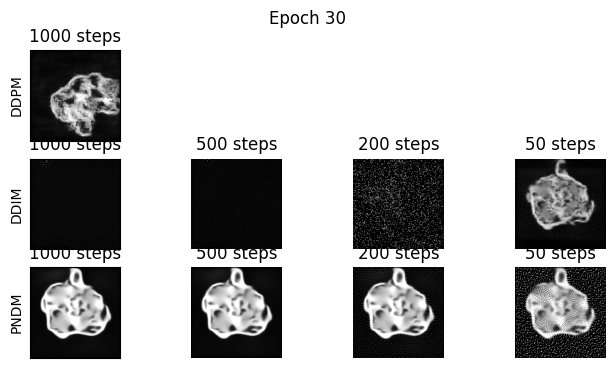

100%|██████████| 50/50 [00:00<00:00, 63.17it/s]


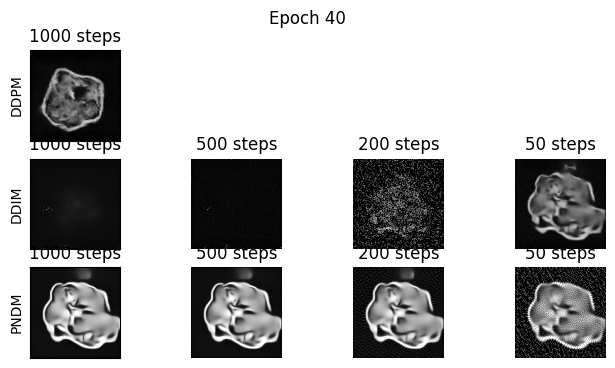

100%|██████████| 50/50 [00:00<00:00, 62.51it/s]


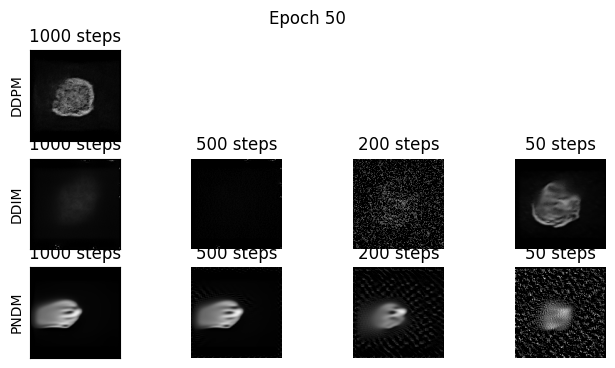

100%|██████████| 50/50 [00:00<00:00, 62.14it/s]


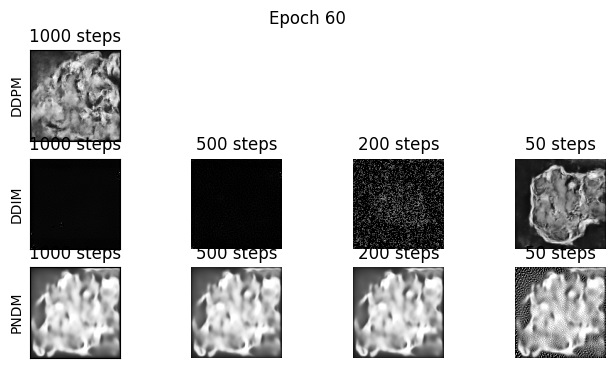

100%|██████████| 50/50 [00:00<00:00, 63.76it/s]


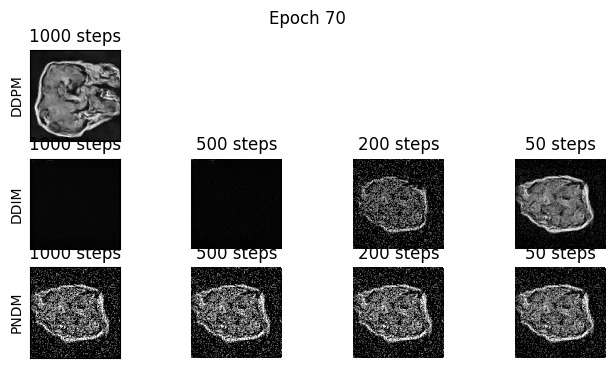

100%|██████████| 50/50 [00:00<00:00, 62.40it/s]


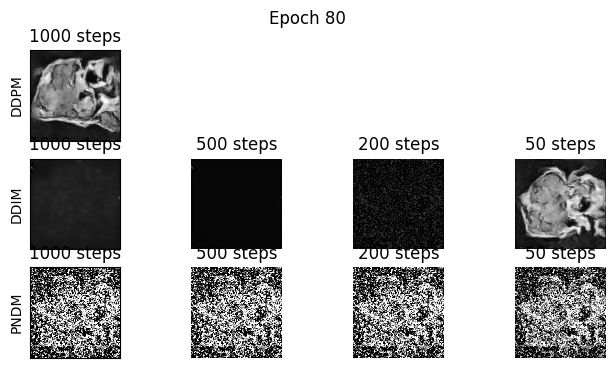

100%|██████████| 50/50 [00:00<00:00, 62.31it/s]


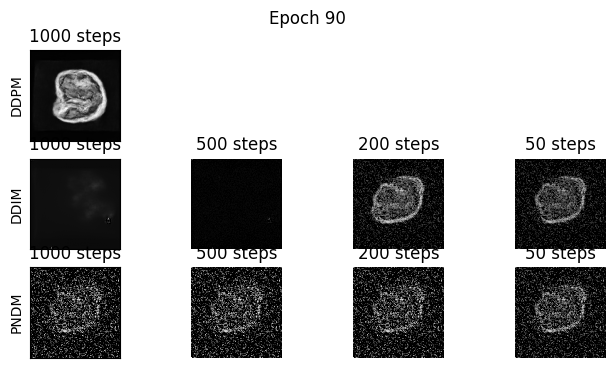

100%|██████████| 50/50 [00:00<00:00, 63.22it/s]


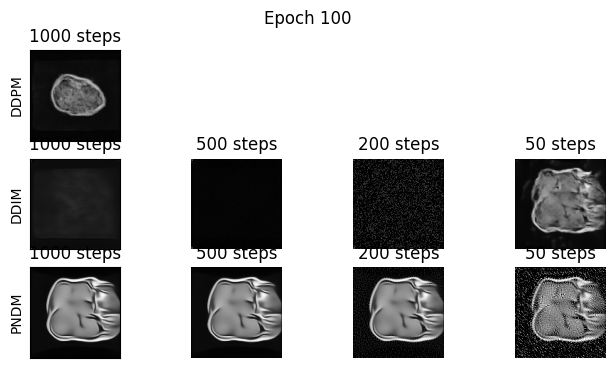

In [8]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 100
    val_interval = 10
    epoch_loss_list = []
    val_epoch_loss_list = []
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            optimizer.zero_grad(set_to_none=True)

            # Randomly select the timesteps to be used for the minibacth
            timesteps = torch.randint(0, ddpm_scheduler.num_train_timesteps, (images.shape[0],), device=device).long()

            # Add noise to the minibatch images with intensity defined by the scheduler and timesteps
            noise = torch.randn_like(images).to(device)
            noisy_image = ddpm_scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)

            # In this example, we are parametrising our DDPM to learn the added noise (epsilon).
            # For this reason, we are using our network to predict the added noise and then using L1 loss to predict
            # its performance.
            noise_pred = model(x=noisy_image, timesteps=timesteps)
            loss = F.l1_loss(noise_pred.float(), noise.float())

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            progress_bar = tqdm(enumerate(val_loader), total=len(train_loader))
            progress_bar.set_description(f"Epoch {epoch} - Validation set")
            for step, batch in progress_bar:
                images = batch["image"].to(device)
                timesteps = torch.randint(
                    0, ddpm_scheduler.num_train_timesteps, (images.shape[0],), device=device
                ).long()
                noise = torch.randn_like(images).to(device)
                with torch.no_grad():
                    noisy_image = ddpm_scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)
                    noise_pred = model(x=noisy_image, timesteps=timesteps)
                    val_loss = F.l1_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 128, 128))
            noise = noise.to(device)
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddpm_scheduler)
            plt.figure(figsize=(8, 4))
            plt.subplot(3, len(sampling_steps), 1)
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            plt.ylabel("DDPM")
            plt.title("1000 steps")
            # DDIM
            for idx, reduced_sampling_steps in enumerate(sampling_steps):
                ddim_scheduler.set_timesteps(reduced_sampling_steps)
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddim_scheduler)
                plt.subplot(3, len(sampling_steps), len(sampling_steps) + idx + 1)
                plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
                plt.ylabel("DDIM")
                if idx == 0:
                    plt.tick_params(
                        top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
                    )
                else:
                    plt.axis("off")
                plt.title(f"{reduced_sampling_steps} steps")
            # PNDM
            for idx, reduced_sampling_steps in enumerate(sampling_steps):
                pndm_scheduler.set_timesteps(reduced_sampling_steps)
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=pndm_scheduler)
                plt.subplot(3, len(sampling_steps), len(sampling_steps) * 2 + idx + 1)
                plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
                plt.ylabel("PNDM")
                if idx == 0:
                    plt.tick_params(
                        top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
                    )
                else:
                    plt.axis("off")
                plt.title(f"{reduced_sampling_steps} steps")
            plt.suptitle(f"Epoch {epoch+1}")
            plt.show()

100%|██████████| 50/50 [00:00<00:00, 62.36it/s]


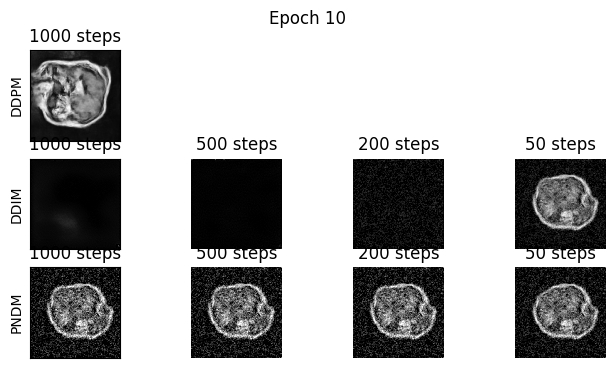

100%|██████████| 50/50 [00:00<00:00, 62.50it/s]


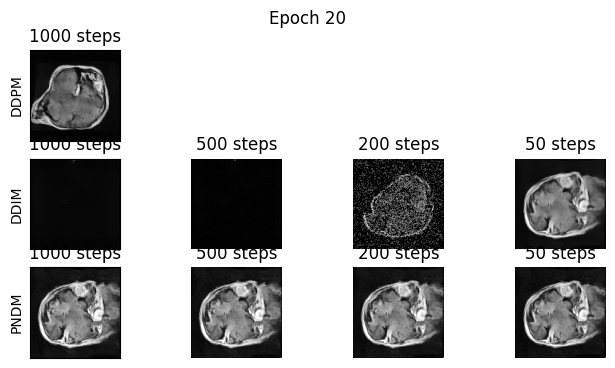

100%|██████████| 50/50 [00:00<00:00, 63.77it/s]


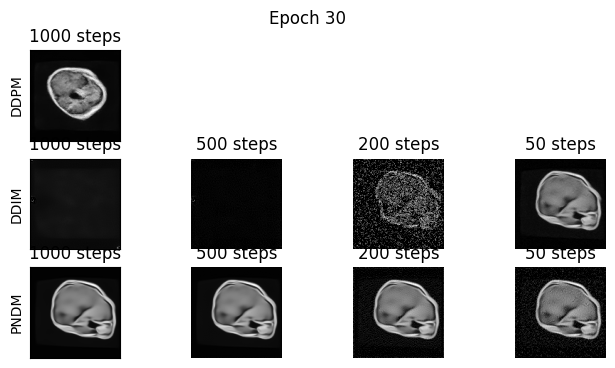

100%|██████████| 50/50 [00:00<00:00, 61.83it/s]


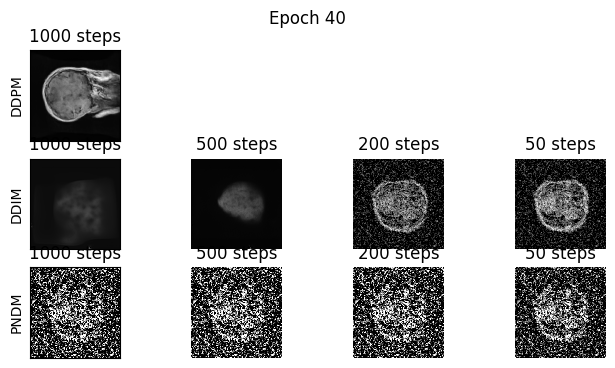

100%|██████████| 50/50 [00:00<00:00, 62.27it/s]


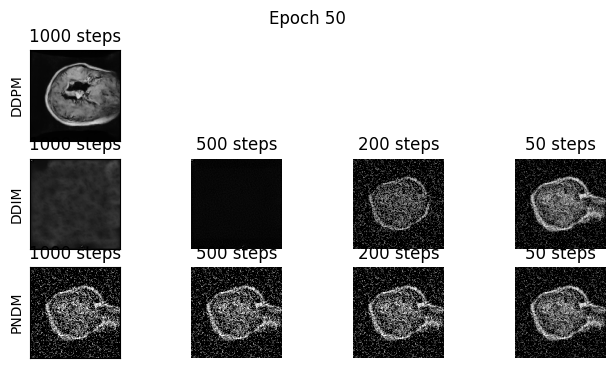

100%|██████████| 50/50 [00:00<00:00, 62.27it/s]


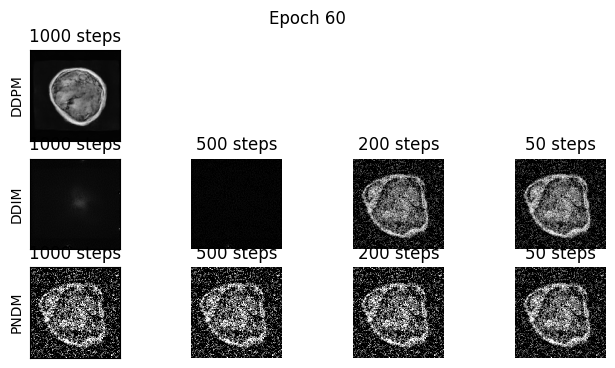

100%|██████████| 50/50 [00:00<00:00, 62.58it/s]


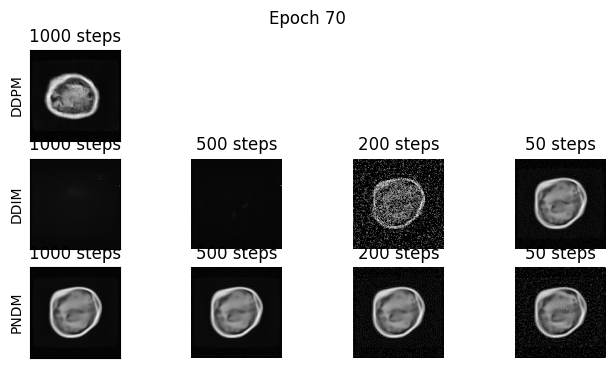

100%|██████████| 50/50 [00:00<00:00, 61.90it/s]


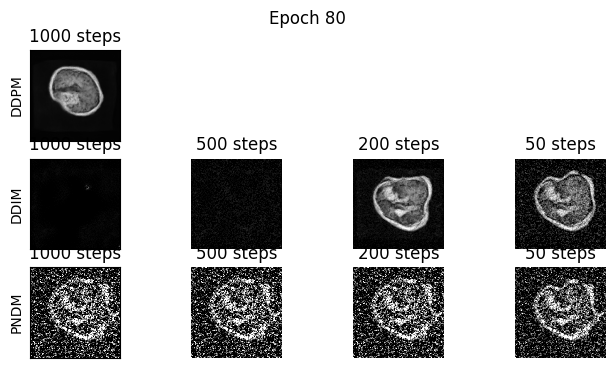

100%|██████████| 50/50 [00:00<00:00, 62.25it/s]


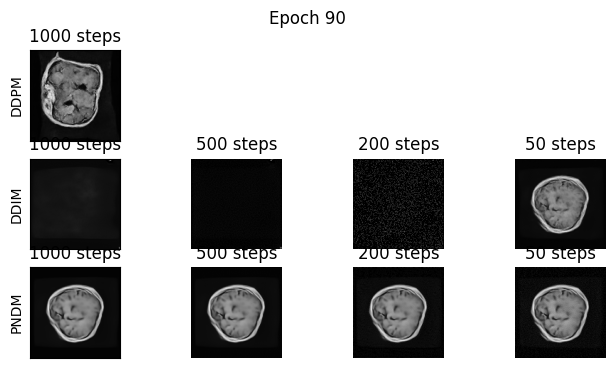

100%|██████████| 50/50 [00:00<00:00, 61.87it/s]


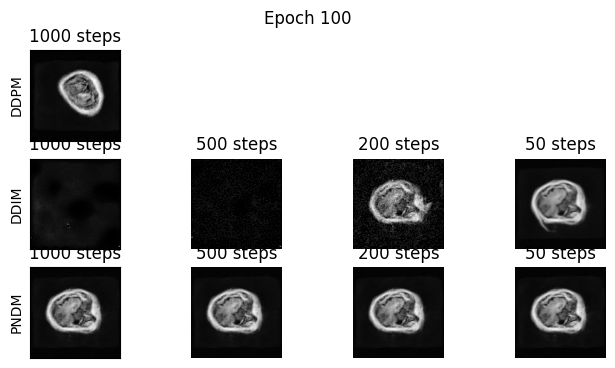

In [15]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 100
    val_interval = 10
    epoch_loss_list = []
    val_epoch_loss_list = []
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            optimizer.zero_grad(set_to_none=True)

            # Randomly select the timesteps to be used for the minibacth
            timesteps = torch.randint(0, ddpm_scheduler.num_train_timesteps, (images.shape[0],), device=device).long()

            # Add noise to the minibatch images with intensity defined by the scheduler and timesteps
            noise = torch.randn_like(images).to(device)
            noisy_image = ddpm_scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)

            # In this example, we are parametrising our DDPM to learn the added noise (epsilon).
            # For this reason, we are using our network to predict the added noise and then using L1 loss to predict
            # its performance.
            noise_pred = model(x=noisy_image, timesteps=timesteps)
            loss = F.l1_loss(noise_pred.float(), noise.float())

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            progress_bar = tqdm(enumerate(val_loader), total=len(train_loader))
            progress_bar.set_description(f"Epoch {epoch+100} - Validation set")
            for step, batch in progress_bar:
                images = batch["image"].to(device)
                timesteps = torch.randint(
                    0, ddpm_scheduler.num_train_timesteps, (images.shape[0],), device=device
                ).long()
                noise = torch.randn_like(images).to(device)
                with torch.no_grad():
                    noisy_image = ddpm_scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)
                    noise_pred = model(x=noisy_image, timesteps=timesteps)
                    val_loss = F.l1_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 128, 128))
            noise = noise.to(device)
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddpm_scheduler)
            plt.figure(figsize=(8, 4))
            plt.subplot(3, len(sampling_steps), 1)
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            plt.ylabel("DDPM")
            plt.title("1000 steps")
            # DDIM
            for idx, reduced_sampling_steps in enumerate(sampling_steps):
                ddim_scheduler.set_timesteps(reduced_sampling_steps)
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddim_scheduler)
                plt.subplot(3, len(sampling_steps), len(sampling_steps) + idx + 1)
                plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
                plt.ylabel("DDIM")
                if idx == 0:
                    plt.tick_params(
                        top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
                    )
                else:
                    plt.axis("off")
                plt.title(f"{reduced_sampling_steps} steps")
            # PNDM
            for idx, reduced_sampling_steps in enumerate(sampling_steps):
                pndm_scheduler.set_timesteps(reduced_sampling_steps)
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=pndm_scheduler)
                plt.subplot(3, len(sampling_steps), len(sampling_steps) * 2 + idx + 1)
                plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
                plt.ylabel("PNDM")
                if idx == 0:
                    plt.tick_params(
                        top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
                    )
                else:
                    plt.axis("off")
                plt.title(f"{reduced_sampling_steps} steps")
            plt.suptitle(f"Epoch {epoch+1}")
            plt.show()

  1%|▏         | 13/1000 [00:00<00:16, 60.21it/s]

100%|██████████| 50/50 [00:00<00:00, 62.83it/s]


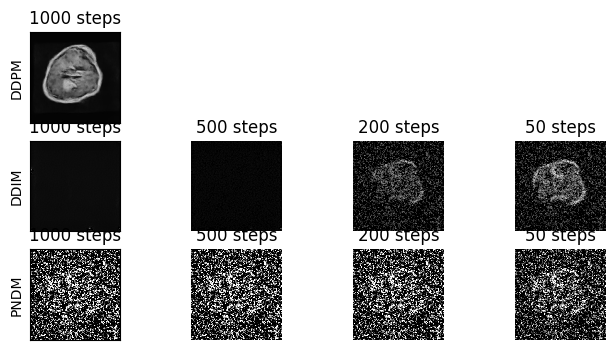

In [14]:
noise = torch.randn((1, 1, 128, 128))
noise = noise.to(device)
image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddpm_scheduler)
plt.figure(figsize=(8, 4))
plt.subplot(3, len(sampling_steps), 1)
plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.ylabel("DDPM")
plt.title("1000 steps")
# DDIM
for idx, reduced_sampling_steps in enumerate(sampling_steps):
    ddim_scheduler.set_timesteps(reduced_sampling_steps)
    image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddim_scheduler)
    plt.subplot(3, len(sampling_steps), len(sampling_steps) + idx + 1)
    plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.ylabel("DDIM")
    if idx == 0:
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    else:
        plt.axis("off")
    plt.title(f"{reduced_sampling_steps} steps")
# PNDM
for idx, reduced_sampling_steps in enumerate(sampling_steps):
    pndm_scheduler.set_timesteps(reduced_sampling_steps)
    image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=pndm_scheduler)
    plt.subplot(3, len(sampling_steps), len(sampling_steps) * 2 + idx + 1)
    plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.ylabel("PNDM")
    if idx == 0:
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    else:
        plt.axis("off")
    plt.title(f"{reduced_sampling_steps} steps")
plt.show()

100%|██████████| 50/50 [00:00<00:00, 62.11it/s]


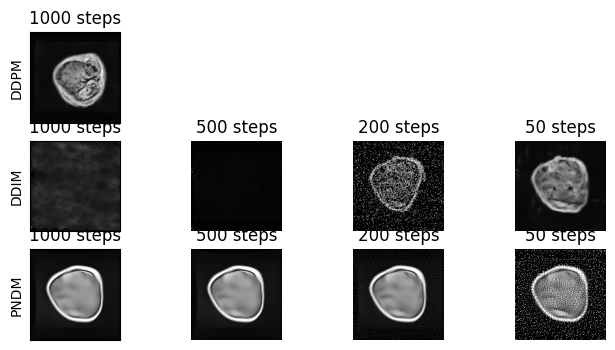

In [16]:
noise = torch.randn((1, 1, 128, 128))
noise = noise.to(device)
image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddpm_scheduler)
plt.figure(figsize=(8, 4))
plt.subplot(3, len(sampling_steps), 1)
plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.ylabel("DDPM")
plt.title("1000 steps")
# DDIM
for idx, reduced_sampling_steps in enumerate(sampling_steps):
    ddim_scheduler.set_timesteps(reduced_sampling_steps)
    image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddim_scheduler)
    plt.subplot(3, len(sampling_steps), len(sampling_steps) + idx + 1)
    plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.ylabel("DDIM")
    if idx == 0:
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    else:
        plt.axis("off")
    plt.title(f"{reduced_sampling_steps} steps")
# PNDM
for idx, reduced_sampling_steps in enumerate(sampling_steps):
    pndm_scheduler.set_timesteps(reduced_sampling_steps)
    image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=pndm_scheduler)
    plt.subplot(3, len(sampling_steps), len(sampling_steps) * 2 + idx + 1)
    plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.ylabel("PNDM")
    if idx == 0:
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    else:
        plt.axis("off")
    plt.title(f"{reduced_sampling_steps} steps")
plt.show()

100%|██████████| 1000/1000 [00:16<00:00, 62.45it/s]


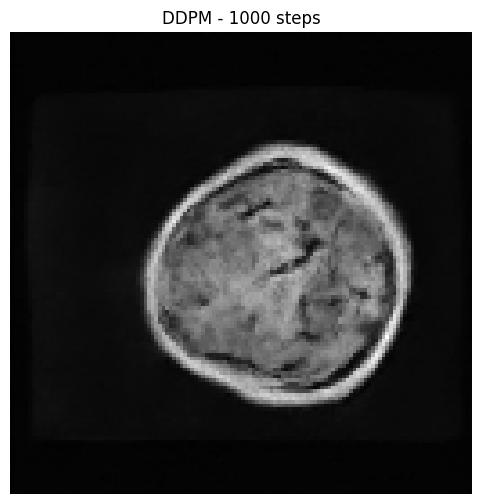

In [40]:
import torch

# Set the number of timesteps for DDIM (adjust as needed)
num_timesteps_ddpm = 1000
ddpm_scheduler.set_timesteps(num_timesteps_ddpm)

# Generate a single image
noise = torch.randn((1, 1, 128, 128)).to(device)  # Generate random noise
image_ddpm = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddpm_scheduler)

# Display the generated image
plt.figure(figsize=(6, 6))
plt.imshow(image_ddpm[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.axis("off")  # Hide axis labels
plt.title(f"DDPM - {num_timesteps_ddpm} steps")
plt.show()

100%|██████████| 50/50 [00:00<00:00, 62.61it/s]


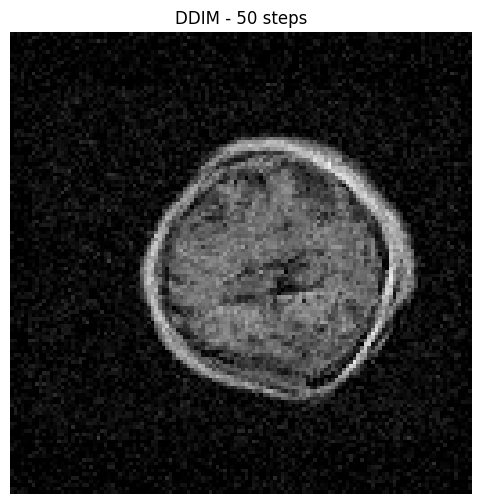

In [44]:
import torch

# Set the number of timesteps for DDIM (adjust as needed)
num_timesteps_ddim = 50  # Example: 50 timesteps
ddim_scheduler.set_timesteps(num_timesteps_ddim)

# Generate a single image
noise = torch.randn((1, 1, 128, 128)).to(device)  # Generate random noise
image_ddim = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddim_scheduler)

# Display the generated image
plt.figure(figsize=(6, 6))
plt.imshow(image_ddim[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.axis("off")  # Hide axis labels
plt.title(f"DDIM - {num_timesteps_ddim} steps")
plt.show()

100%|██████████| 50/50 [00:00<00:00, 63.38it/s]


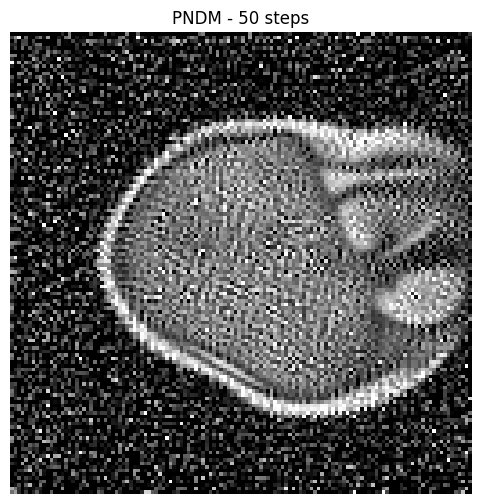

In [39]:
import torch

# Set the number of timesteps for DDIM (adjust as needed)
num_timesteps_pndm = 50
pndm_scheduler.set_timesteps(num_timesteps_pndm)

# Generate a single image
noise = torch.randn((1, 1, 128, 128)).to(device)
image_pndm = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=pndm_scheduler)

# Display the generated image
plt.figure(figsize=(6, 6))
plt.imshow(image_pndm[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.axis("off")  # Hide axis labels
plt.title(f"PNDM - {num_timesteps_pndm} steps")
plt.show()